<a href="https://colab.research.google.com/github/Vishwa172107/Facial_Expression_Recognition-using-PyTorch/blob/main/Facial_Expression_Recognition_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **1. Start by getting some data:**

We can use this code to import a dataset from Kaggle


In [1]:
#this code is to import the dataset from the Kaggle website
! kaggle datasets download mahmoudima/mma-facial-expression
!unzip -q mma-facial-expression.zip

Dataset URL: https://www.kaggle.com/datasets/mahmoudima/mma-facial-expression
License(s): unknown
 96% 159M/166M [00:01<00:00, 107MB/s] 
100% 166M/166M [00:01<00:00, 91.9MB/s]


In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt

In [3]:
#transform for the data... You can also change the size of images using resize
#but then we have to change the parameters for our model
transform = transforms.Compose([
    transforms.ToTensor(),           # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize image data
                         std=[0.229, 0.224, 0.225])
])
#setup device agnostic code...
#This sets the device to "cuda" if a GPU is available
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
dataset = datasets.ImageFolder('/content/MMAFEDB/train', transform=transform)

In [5]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [6]:
#The ground truth labels in our dataset
dataset.classes

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [7]:
#map of each class to a value
dataset.class_to_idx

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [8]:
#check how many samples we have from each class
for i in range(7):
    print(dataset.targets.count(i))

6566
3231
4859
28592
29384
12223
8113


In [9]:
#Loading the test and Validarion data
dt = datasets.ImageFolder('/content/MMAFEDB/test', transform=transform)
dtt = DataLoader(dt, batch_size=32, shuffle=True)

valid = datasets.ImageFolder('/content/MMAFEDB/valid', transform=transform)
validt = DataLoader(valid, batch_size=32, shuffle=True)

In [10]:
#shows gpu that we are using... If we have one...
!nvidia-smi

Mon Nov  4 03:44:00 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [11]:
for batch in dtt:
    images, labels = batch
    break
images.shape

torch.Size([32, 3, 48, 48])

In [12]:
class Facial_Expression_ModelV1(nn.Module):
    def __init__(self, input_features, hidden, output_features, n):
        super().__init__()
        #create few Layer Stack, (they can vary in number.) and use functions to implement each layer
        self.Stack_1 = nn.Sequential(
            nn.Conv2d(input_features, hidden, 3, 1, 0),
            nn.ReLU(),
            nn.Conv2d(hidden, hidden, 3, 1, 0),
            nn.ReLU(),
            nn.MaxPool2d(2, 1, 0)
        )
        self.Stack_2 = nn.Sequential(
            nn.Conv2d(hidden, hidden, 3, 1, 0),
            nn.ReLU(),
            nn.Conv2d(hidden, hidden, 3, 2, 0),
            nn.ReLU(),
            nn.MaxPool2d(2, 1, 0),
            nn.Conv2d(hidden, output_features, 3, 1, 0)
        )
        self.Linearize = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=n, out_features=7),
        )

    #override/ Implement the forward() to implement the model
    def forward(self, X):
        X = self.Stack_1(X)
        X = self.Stack_2(X)
        X = self.Linearize(X)
        return X

In [13]:
#Create the object of the class that we created and send it to device i.e. "Device Agnostic Code"
#torch.manual_seed(seed) this is useful to reproduce the same weights each time we run the cell
torch.manual_seed(43)

#the parameters depend on the image size
model_1 = Facial_Expression_ModelV1(3, 120, 7, 2023).to(device)

model_1

Facial_Expression_ModelV1(
  (Stack_1): Sequential(
    (0): Conv2d(3, 120, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(120, 120, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (Stack_2): Sequential(
    (0): Conv2d(120, 120, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(120, 120, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(120, 7, kernel_size=(3, 3), stride=(1, 1))
  )
  (Linearize): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2023, out_features=7, bias=True)
  )
)

In [14]:
#check the shape of a Single batch of images
images.shape

torch.Size([32, 3, 48, 48])

In [15]:
#sending the data to device to avoid Device errors
A = images.to(device)
A.device
labels = labels.to(device)

In [16]:
#this flattens i.e. converts n-dim tansor into a 1-dim vector
nn.Flatten()(images).shape

torch.Size([32, 6912])

In [17]:
#pass a single batch to see if the model works the way we want it to
A = model_1(A)
A = torch.softmax(A, dim=1).argmax(dim=1)
A==labels

tensor([False, False,  True, False,  True, False,  True, False, False, False,
         True,  True, False,  True, False, False,  True, False, False, False,
        False,  True, False, False,  True, False,  True,  True, False, False,
        False,  True], device='cuda:0')

In [18]:
#Choose a Loss Function to check "How wrong your Model is..."
loss_fn = nn.CrossEntropyLoss()

#Choose a Optimizer function to update the weights after each epoch...
#Note that setting the Learning_Rate (lr) too high could result in NaN errors
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.01)

In [19]:
print(len(dataloader))

2906


In [20]:
#custom function to calculate the accuracy based on the Prediction and Ground Truths
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [21]:
#A function to pass a single batch of Training set images to the Neural Network Model
def train_loop(X, y, Batch):
    #set the model to Training mode
    model_1.train()

    #forward pass
    preds = model_1(X)

    #calculate the loss
    loss = loss_fn(preds, y)
    y_preds = torch.softmax(preds, dim=1).argmax(dim=1)
    acc = accuracy_fn(y, y_preds)

    #optimizer reset the Gradients
    optimizer.zero_grad()

    #BackPropogation
    loss.backward()

    #updating the weights
    optimizer.step()

    #print for every 1000th batch
    # if Batch%1000==0:
    #     print(f"Training {Batch}... Loss:{loss:.4f}, accuracy:{acc:.2f}")
    return (acc, loss)

In [22]:
#A function to pass a single batch of Validation data to check the model accuracy after each epoch of Training set
def test_loop(X, y, Batch):
    #set the model to test/eval mode
    model_1.eval()

    #use torch.inference_mode() for enhanced performance
    with torch.inference_mode():
        #pass the data
        preds = model_1(X)
        #calculate the loss
        loss = loss_fn(preds, y)
        y_preds  =torch.softmax(preds, dim=1).argmax(dim=1)
        acc = accuracy_fn(y, y_preds)

    # if Batch%200==0:
    #     print(f"Testing {Batch}... Loss:{loss:.4f}, accuracy:{acc:.2f}")
    return (acc, loss)

In [23]:
#change the no of epochs for improving your model accuracy by training it longer
epochs = 40
for epoch in range(epochs):
    print(f"Epoch no.:{epoch}")
    Train_loss, Train_acc = 0., 0.
    Validation_loss, Validation_acc = 0., 0.
    for batch, (X,y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        a, l = train_loop(X, y, batch)
        Train_acc += a
        Train_loss += l
    Train_acc /= len(dataloader)
    Train_loss /= len(dataloader)
    for batch, (X, y) in enumerate(validt):
        X = X.to(device)
        y = y.to(device)
        ta, tl = test_loop(X, y, batch)
        Validation_acc += ta
        Validation_loss += tl
    Validation_loss /= len(validt)
    Validation_acc /= len(validt)

    print(f"Average Metrics...\nTrain_loss:{Train_loss:.4f} | Train_acc:{Train_acc:.2f} | Validate_loss:{Validation_loss:.4f} | Validate_acc:{Validation_acc:.2f}")

Epoch no.:0
Average Metrics...
Train_loss:1.4899 | Train_acc:44.10 | Validate_loss:1.5407 | Validate_acc:42.71
Epoch no.:1
Average Metrics...
Train_loss:1.3006 | Train_acc:53.49 | Validate_loss:1.4426 | Validate_acc:45.28
Epoch no.:2
Average Metrics...
Train_loss:1.1936 | Train_acc:57.48 | Validate_loss:1.4362 | Validate_acc:46.66
Epoch no.:3
Average Metrics...
Train_loss:1.1343 | Train_acc:59.69 | Validate_loss:1.7692 | Validate_acc:37.65
Epoch no.:4
Average Metrics...
Train_loss:1.0959 | Train_acc:61.09 | Validate_loss:1.4717 | Validate_acc:47.14
Epoch no.:5
Average Metrics...
Train_loss:1.0647 | Train_acc:62.11 | Validate_loss:1.3724 | Validate_acc:49.56
Epoch no.:6
Average Metrics...
Train_loss:1.0380 | Train_acc:63.14 | Validate_loss:1.3642 | Validate_acc:51.40
Epoch no.:7
Average Metrics...
Train_loss:1.0141 | Train_acc:64.08 | Validate_loss:1.3656 | Validate_acc:50.82
Epoch no.:8
Average Metrics...
Train_loss:0.9925 | Train_acc:64.85 | Validate_loss:1.4742 | Validate_acc:48.32
E

KeyboardInterrupt: 

In [24]:
#Test the model with the Test data
Test_acc, Test_loss = 0., 0.
for batch, (X, y) in enumerate(dtt):
    X = X.to(device)
    y = y.to(device)
    ta, tl = test_loop(X, y, batch)
    Test_acc += ta
    Test_loss += tl
Test_loss /= len(dtt)
Test_acc /= len(dtt)

print(f"Testing... Loss:{Test_loss:.4f}, accuracy:{Test_acc:.2f}")

Testing... Loss:1.4080, accuracy:51.93


<Axes: >

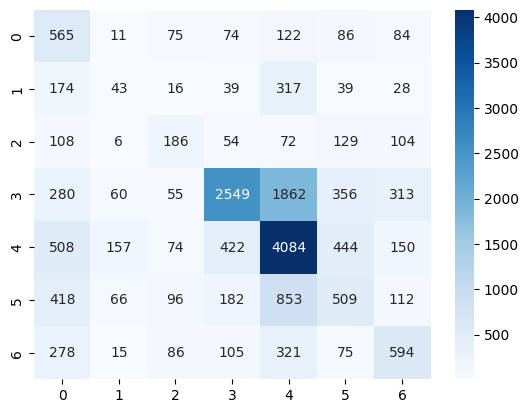

In [25]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
a = []
Y = []
#take test data to visualize in a confusion matrix
for batch, (X, y) in enumerate(validt):
    a.extend(torch.softmax(model_1(X.to(device)).to("cpu"), dim=1).argmax(dim=1))
    Y.extend(y)
A = confusion_matrix(Y, a)
sns.heatmap(A, cmap="Blues", annot=True, fmt="g")